# Trainig a Model Using the MNIST datase for recgonise hand-writen digits
    On this notebook we show how to create a model using  MNIST dataset.
    We start showing how to read the bits from the dataset, then we do a quick introduction to neural network what 
    is useful for understand the model thath we will train.
    We start with a simple linear model, 



  [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/) 

# The Data

  We will start by undertandig how the data is formated and parsing it i a suuitable way for train our model.
  
  Mnist provide 4 files: 



## Little and Big Endian Architecture 

  There are 2 types of processors architecture(litle and big endian). In litle endian bits are store from left to righ This is basically how the bytes are stored, in litle they are stored from left to right and in big the other way around.(Look this is you want to know more about https://chortle.ccsu.edu/AssemblyTutorial/Chapter-15/ass15_3.html ).
  This is relevant for us because we need to know read the bytes right for get the proper data.
  In python we can easyle check using sys, since I am using a Intel processor i expected to be litle.

In [1]:
import numpy as np
from sys import byteorder

Now we can check  our architecture:

In [2]:
print(byteorder)

little


## Reading Mnist

  Now we can start reading the train images file. 
  From Mnist webstie we know what to expected from each bit readed.
   

In [3]:
import gzip

with gzip.open('mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    fc_train_img = f.read()

  The first 4 bytes is the magic number which is a 32 bit integer, for the image set this number is 2051. Note that we are setting the byteorder as big.

In [4]:
int.from_bytes(fc_train_img[0:4], byteorder='big')

2051

 Next is the the number of images as a 32 bit integer:

In [5]:
train_img_total = int.from_bytes(fc_train_img[4:8], byteorder='big')
train_img_total

60000

Then number of rows as 32 bit integer.

In [6]:
row = int.from_bytes(fc_train_img[8:12], byteorder='big')
row

28

And a columns as 32 bit integer.

In [7]:
col = int.from_bytes(fc_train_img[12:16], byteorder='big')
col

28

Then unsigned bytes(8 bits) , each byte represent a pixel. They are orginezed row-wise.

The total of bits is : 
```python
train_img_total*row*col
```





In [8]:
last_byte = (train_img_total*row*col) + 16
last_byte

47040016

Now whe can read all bits:

In [9]:
x_train = list(fc_train_img[16:last_byte])

And reshape them ass 28*27 (784) array. They represent our vector.

Also in Mnist pixel values are 0 to 255.0 , 0 representing the background. We want ot invert this, because having a non zero value as background is better for the trainig. 

In [10]:
x_train = ~np.array(x_train).reshape(train_img_total,row*col).astype(np.uint8)
x_train.shape

(60000, 784)

We can see one image using pyplot:

In [11]:
import matplotlib.pyplot as plt
plt.imshow(x_train[11].reshape(row,col), cmap='gray')

Thats look like the image 11 is a 5. We can now read labels and check.

In [12]:
with gzip.open('mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    fc_train_lbl = f.read()

First 32 bits are magin number : 2049

In [13]:
int.from_bytes(fc_train_lbl[0:4], byteorder='big')


2049

Then a 32 bits intiger, the total of labels. Must be 6000 as we got 6000 images. 

In [14]:
train_lvl_total = int.from_bytes(fc_train_lbl[4:8], byteorder='big')
train_lvl_total

60000

Now each unsigned byte is a label, so we can check that 11 is 5:

In [15]:
y_train = np.array(list(fc_train_lbl[8:train_lvl_total+8]))
print(y_train[11])

5


We now real the test images and labels:

In [16]:
with gzip.open('mnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    fc_test_img = f.read()
with gzip.open('mnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    fc_test_lbl = f.read()
    
test_img_total = int.from_bytes(fc_test_img[4:8], byteorder='big')
test_lbl_total = int.from_bytes(fc_test_lbl[4:8], byteorder='big')

last_byte = (test_img_total*row*col) + 16
x_test = list(fc_test_img[16:last_byte])
x_test = ~np.array(x_test).reshape(test_img_total,row*col).astype(np.uint8)

y_test = np.array(list(fc_test_lbl[8:test_lbl_total+8]))

In [17]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [18]:
x_train =  x_train/255.0
x_test = x_test/255.0

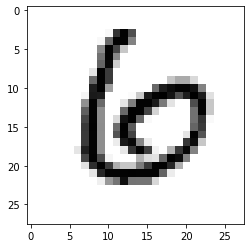

In [19]:
plt.imshow(x_test[11].reshape(row,col), cmap='gray')

In [20]:
print(y_test[11])

6


# Neuron Network

Most peope can recognize handwrite digits with no problem(beacuse we have a very complex brain). This is not a easy task for a computer. We will use the neural netwok aproach, we will take a large number of labeled handwrite digits -the training examples- (<b>x_train</b>), and create a model that can learn from those examples.


## Neurons

 The idea is simple, they take several imputs(  $ x_1, x_2 ... x_n $) and produce a single output.




![Single neuron](img/SingleNeuron.png)

Each input have  <i>weights</i>  $ w_1, w_2 ... w_n $ , a weight sum is calculated:${\sum_n x_n w_n}$ then the results goes through a activation function.

[http://neuralnetworksanddeeplearning.com/chap1.html](http://neuralnetworksanddeeplearning.com/chap1.html/) 

[https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb](https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb) 



## Layers

We create layers composed of neurons. at least one input layer and a output layer is required, there can be hidden layers between the input and output layer. 

Our images are 28x28, we can create a 784 vector that represent the image. So we will feed out network with 784 inputs, this is our input layer that is also know as hidden layer.
Since we need to discriminate 10 numbers out output layer will have 10 neurons, each will represent a digit from 0 to 9. Then we can use SoftMax activation function for the output of each of our network to represent a probability of being a digit.


## Activation : softmax
  We want our result to represent a probablility of being one of the 10 digits(0,1,3...).
  The softmax activation function will do this for us, it will output our output for each neuron beetwen 0 and 1.Then each 
  of our neuron can represent a a digit so the one will bigger probability will be our prediction.
  
  $$\sigma (z)_j = \frac{e^{(z)_j}}{\sum_{k=0}^{K}e^{(z)_k}} \text{  where   j = 1,...,K}$$  
  
  In our case K = 10.
  
  https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/

## First model

 We will start create a 2 layers model, input and output : the input layer will be the 784 vector created with the image data and the output a 10 neuros with activation softmax. 
 

![Single neuron](img/Model1.png)

In [21]:
import keras as kr

Using TensorFlow backend.


In [57]:
# create sequeantial model
model = kr.models.Sequential()

# The input layer is added by keras when we set input = 784 
# We add 10 neuroas with softmax for output
model.add(kr.layers.Dense(units=10, input_dim=784, activation='softmax'))

# Compile the model.
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

We can se a summary of our model:

In [58]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


The 7850 parameters are:
 10 weights from each input node to each output made 7840 plus 10 weightns on the outputs nodes.

We are missing few thinks to explain: loss,optimizer and metrics. 

In [29]:
np.argmax(result, axis=-1)[0]

0

## Loss : categorical_crossentropy

    After we calculate our result we need to calculate the distance beetween our prediction and our epected result.
    https://algorithmia.com/blog/introduction-to-loss-functions
    

## Optimazer : adam
https://algorithmia.com/blog/introduction-to-optimizers

## Preparing the labes
    
We are almost done for train our model for first time, the only problems is that our labels are a single digit. We need make theem vectors with a 1 on the number position. 

In [30]:
y_train = kr.utils.to_categorical(y_train, 10)
y_test  = kr.utils.to_categorical(y_test, 10)

In [31]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

Now we are ready, we will start training this simple model with 10 epochs, batch of 100 (means we train the model with 100 images at a time).

In [32]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.7984 - accuracy: 0.7896 - val_loss: 0.4558 - val_accuracy: 0.8742
Epoch 2/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.4288 - accuracy: 0.8787 - val_loss: 0.3679 - val_accuracy: 0.8991
Epoch 3/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3751 - accuracy: 0.8927 - val_loss: 0.3373 - val_accuracy: 0.9015
Epoch 4/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3525 - accuracy: 0.8982 - val_loss: 0.3276 - val_accuracy: 0.9051
Epoch 5/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3396 - accuracy: 0.9018 - val_loss: 0.3124 - val_accuracy: 0.9082
Epoch 6/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3304 - accuracy: 0.9043 - val_loss: 0.3304 - val_accuracy: 0.8991
Epoch 7/10
60000/60000 [==============================] - 1s 22us/st

## First results

 We have achived a 99.67 accuracy with this very simple model, this is going to be our baseline and we change our model for improve the results

We can get data history, since we will be doing this several times i also define a function for use later.

In [43]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])
def get_stats():
    val_accuracy = np.array(history_callback.history['val_accuracy'])
    val_loss =  np.array(history_callback.history['val_loss'])
    accuracy =  np.array(history_callback.history['accuracy'])
    loss =  np.array(history_callback.history['loss'])
              

In [44]:
getStats()

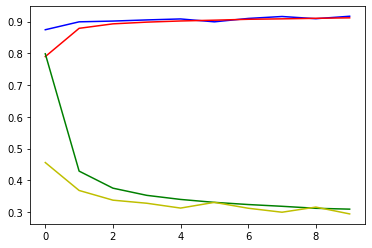

In [51]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

- Red : Test accuracy.
- Blue : Train accuracy.
- Green : Train loss.
- Yellow: Test loss.

# Adding more Layers and Relu activation function

# Relu

Rectified linea unit(Relu), is one of the most common activation functions in neural networks. Relu is very simple, linear for all positive valueas and 0 for all negative values:
$$ f(x)       \begin{cases}
       \text{0,} &\quad\text{if } x \le0\\
       f(x) &\quad\text{if } x  >0 \\
       \end{cases}$$


![Relu](img/relu.png)

# Some advantages of Relu:
- Cheap to compute.
- Good sparsity.
- Converge faster.

[https://keras.io/activations/](https://keras.io/activations/)

[https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7) 

[https://datascience.stackexchange.com/questions/14349/difference-of-activation-functions-in-neural-networks-in-general](https://datascience.stackexchange.com/questions/14349/difference-of-activation-functions-in-neural-networks-in-general)

## Extra layers

We can now add more layers using relu activation function:
- Same input layer.
- " hiddens laters  512 and 98 neuors, with relu.
- Same output layer, 10 neurons with softmax.

In [59]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(units=512, input_dim=784, activation='relu'))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [61]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_7 (Dense)              (None, 98)                50274     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                990       
Total params: 453,184
Trainable params: 453,184
Non-trainable params: 0
_________________________________________________________________


In [62]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.5527 - accuracy: 0.8314 - val_loss: 0.3170 - val_accuracy: 0.9079
Epoch 2/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.3111 - accuracy: 0.9060 - val_loss: 0.2620 - val_accuracy: 0.9165
Epoch 3/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.2363 - accuracy: 0.9280 - val_loss: 0.1919 - val_accuracy: 0.9416
Epoch 4/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1906 - accuracy: 0.9416 - val_loss: 0.1508 - val_accuracy: 0.9544
Epoch 5/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1608 - accuracy: 0.9505 - val_loss: 0.1408 - val_accuracy: 0.9561
Epoch 6/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1454 - accuracy: 0.9548 - val_loss: 0.1385 - val_accuracy: 0.9544
Epoch 7/10
60000/60000 [==============================] - 2s 28us/st

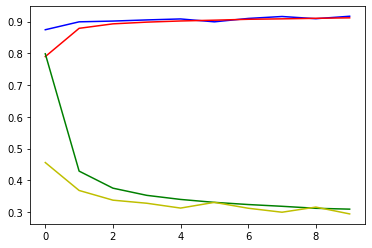

In [64]:
getStats()
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

Relu and the extra layers have give a greeat improvement to our model, from 91% to 96.5%. 

# Dropout

Drop out is regularization technic, basically we drop some random neurons during trainig, 
they are temporary shuttend down. 

Is belive that this make other neurons be more active so improve the learning rate.

The effect is a network taht is less sensitive to specific weights of neurons. The netwoek is capable of a better generalizaion and avoid overfit.

Drop out is very easily implemented with keras, we just need to pick a percent of dropped out neurons for each epoch.

[https://keras.io/layers/core/](https://keras.io/layers/core/)

[https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

In [65]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(units=512, input_dim=784, activation='relu'))
model.add(kr.layers.Dropout(0.01))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 98)                50274     
_________________________________________________________________
dropout_4 (Dropout)          (None, 98)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                990       
Total params: 453,184
Trainable params: 453,184
Non-trainable params: 0
_________________________________________________________________


In [68]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.1126 - accuracy: 0.9652 - val_loss: 0.0976 - val_accuracy: 0.9692
Epoch 2/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.1047 - accuracy: 0.9668 - val_loss: 0.1214 - val_accuracy: 0.9620
Epoch 3/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.1027 - accuracy: 0.9678 - val_loss: 0.0857 - val_accuracy: 0.9733
Epoch 4/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.0970 - accuracy: 0.9689 - val_loss: 0.0892 - val_accuracy: 0.9704
Epoch 5/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.0907 - accuracy: 0.9716 - val_loss: 0.1268 - val_accuracy: 0.9624
Epoch 6/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.0925 - accuracy: 0.9701 - val_loss: 0.0963 - val_accuracy: 0.9710
Epoch 7/10
60000/60000 [==============================] - 2s 32us/st

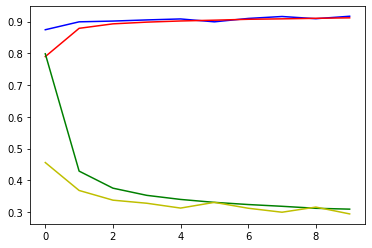

In [69]:
getStats()
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

Dropout improve our model from 96.5% to 97%, so now we are at 97%.

# 2D Convolutional Neural Network

We have achiave 97% accuracy on our model, but we are missing a very importan point : shapes are 2D images and there is a relation beetween pixels. Transforming our image in a 1D vector we completaly ignore the shape of the image.
Using convolutional neurons we can feed neurons with 2D arrays of pixels and someone preserve the data on the shape of the image.

In the image bellow we can see how a 3x3 convolutional networds works.Note that the image is just for ilustrate how convolutional networls works, is not related with the one we will use.

![Conv2d](img/conv2d.gif)

### image from:  [https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)

[https://keras.io/layers/convolutional/](https://keras.io/layers/convolutional/)

[https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

## Reforating input data for convolutional network

We now need to reshape our data for be a 28 by 28 array so it can be fit onto the convolutional network.

In [72]:
x_train = x_train.reshape(train_img_total,col,row,1)
x_test = x_test.reshape(test_img_total,col,row,1)

In [73]:
model = kr.models.Sequential()

model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [74]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 247us/step - loss: 0.4826 - accuracy: 0.8633 - val_loss: 0.1012 - val_accuracy: 0.9709
Epoch 2/10
60000/60000 [==============================] - 12s 202us/step - loss: 0.1204 - accuracy: 0.9634 - val_loss: 0.0761 - val_accuracy: 0.9757
Epoch 3/10
60000/60000 [==============================] - 12s 202us/step - loss: 0.0805 - accuracy: 0.9746 - val_loss: 0.0659 - val_accuracy: 0.9783
Epoch 4/10
60000/60000 [==============================] - 12s 203us/step - loss: 0.0603 - accuracy: 0.9802 - val_loss: 0.0556 - val_accuracy: 0.9815
Epoch 5/10
60000/60000 [==============================] - 12s 201us/step - loss: 0.0468 - accuracy: 0.9847 - val_loss: 0.0565 - val_accuracy: 0.9834
Epoch 6/10
60000/60000 [==============================] - 12s 204us/step - loss: 0.0340 - accuracy: 0.9889 - val_loss: 0.0607 - val_accuracy: 0.9819
Epoch 7/10
60000/60000 [==============================] 

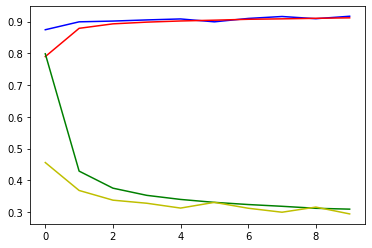

In [75]:
getStats()
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

With just 1 convolutional layer we have improve our accuracy to 98%

## More layers and max polling

A polling layer is a layer that we add aftter a convolutional layer.  The polling layer will operate over each pixel for create a new set of pulled data. We will use max polling of size 2x2 pixels. This means that the maximun of each 2x2 patch will be calculated.

### Benefits:

- Model invariance to local translation.
- Faster computations.
- 


![MAxPolling2d](img/maxpolling2d.png)

image from: [https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/](https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/)

[https://keras.io/layers/pooling/](https://keras.io/layers/pooling/)

[https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)

In [95]:
class CustomModelCheckpoint(kr.callbacks.Callback):
    minimun = 0.99
   

    def on_epoch_end(self, epoch, logs=None):
        score = self.model.evaluate(x_test, y_test, verbose=0)
        # logs is a dictionary
        print(f"epoch: {epoch},history_callback.{logs['val_accuracy']}")
        print(score[1])
        if score[1] > self.minimun: # your custom condition
    
            self.model.save('model7.h5', overwrite=True)
           
            print("saved")
            
           
            
            self.minimun = score[1]
            print(self.minimun)

In [96]:
cbk = CustomModelCheckpoint()
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100, callbacks=[cbk])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 1s 23us/step - loss: 0.4282 - accuracy: 0.8800 - val_loss: 0.3694 - val_accuracy: 0.8938
epoch: 0,history_callback.0.8938000202178955
0.8938000202178955


In [97]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(units=512, input_dim=784, activation='relu'))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])


In [98]:
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100,
                             callbacks=[cbk])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 29us/step - loss: 0.5665 - accuracy: 0.8362 - val_loss: 0.3347 - val_accuracy: 0.9047
epoch: 0,history_callback.0.904699981212616
0.904699981212616


In [99]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

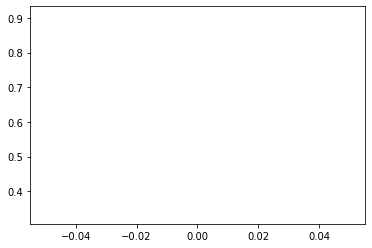

In [100]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,x,accuracy,x,loss,x,val_loss)

In [52]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(units=512, input_dim=784, activation='relu'))
model.add(kr.layers.Dropout(0.01))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [54]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)
                             #, callbacks=[cbk])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.5696 - accuracy: 0.8244 - val_loss: 0.2744 - val_accuracy: 0.9171
Epoch 2/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.3054 - accuracy: 0.9071 - val_loss: 0.2449 - val_accuracy: 0.9240
Epoch 3/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.2369 - accuracy: 0.9272 - val_loss: 0.2228 - val_accuracy: 0.9286
Epoch 4/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.2015 - accuracy: 0.9371 - val_loss: 0.1543 - val_accuracy: 0.9513
Epoch 5/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.1737 - accuracy: 0.9458 - val_loss: 0.1484 - val_accuracy: 0.9531
Epoch 6/10
60000/60000 [==============================] - 2s 33us/step - loss: 0.1555 - accuracy: 0.9516 - val_loss: 0.1545 - val_accuracy: 0.9518
Epoch 7/10
60000/60000 [==============================] - 2s 33us/st

In [103]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

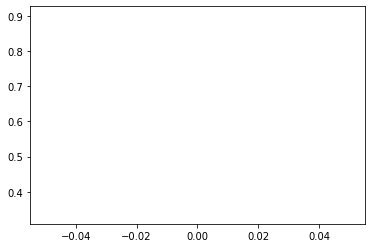

In [104]:

x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,x,accuracy,x,loss,x,val_loss)

In [105]:
score = kr.models.load_model('./model1.h5').evaluate(x_test, y_test, verbose=0)
score

ValueError: Error when checking input: expected conv2d_13_input to have 4 dimensions, but got array with shape (10000, 784)

In [32]:
x_train = x_train.reshape(train_img_total,col,row,1)
x_test = x_test.reshape(test_img_total,col,row,1)

In [107]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [108]:
epoch = 1
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100
                             , callbacks=[cbk])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 6s 101us/step - loss: 0.2193 - accuracy: 0.9301 - val_loss: 0.0546 - val_accuracy: 0.9828
epoch: 0,history_callback.0.9828000068664551
0.9828000068664551


In [109]:
score = kr.models.load_model('./model1.h5').evaluate(x_test, y_test, verbose=0)
score

[0.04757987779821233, 0.9961000084877014]

In [110]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [111]:
epoch = 1
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100
                             , callbacks=[cbk])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 6s 102us/step - loss: 0.2160 - accuracy: 0.9311 - val_loss: 0.0476 - val_accuracy: 0.9853
epoch: 0,history_callback.0.9853000044822693
0.9853000044822693


In [112]:
score = kr.models.load_model('./model1.h5').evaluate(x_test, y_test, verbose=0)
score

[0.04757987779821233, 0.9961000084877014]

In [113]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
kr.layers.normalization.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
kr.layers.normalization.BatchNormalization(axis=-1)
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss=kr.losses.categorical_crossentropy,optimizer='adadelta',metrics=['accuracy'])
model.summary()
 



Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 22, 22, 64)        3200      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        200768    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 4, 128)         204928    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 2, 2, 256)         295168    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 1, 256)       

In [114]:
from keras.preprocessing.image import ImageDataGenerator

In [115]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
test_gen = ImageDataGenerator()

In [116]:
train_generator = gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_test, y_test, batch_size=64)

In [127]:
epoch =10
history_callback= model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=epoch, 
                    validation_data=test_generator, validation_steps=10000//64, callbacks=[cbk])

Epoch 1/10
937/937 [==============================] - 11s 11ms/step - loss: 0.0093 - accuracy: 0.9976 - val_loss: 3.7253e-09 - val_accuracy: 0.9944
epoch: 0,history_callback.0.9943910241127014
0.9944000244140625
Epoch 2/10
937/937 [==============================] - 12s 12ms/step - loss: 0.0093 - accuracy: 0.9979 - val_loss: 1.3038e-07 - val_accuracy: 0.9950
epoch: 1,history_callback.0.9949678182601929
0.9950000047683716
Epoch 3/10
937/937 [==============================] - 10s 11ms/step - loss: 0.0105 - accuracy: 0.9975 - val_loss: 6.8649e-06 - val_accuracy: 0.9945
epoch: 2,history_callback.0.9944645762443542
0.9944999814033508
Epoch 4/10
937/937 [==============================] - 11s 11ms/step - loss: 0.0111 - accuracy: 0.9975 - val_loss: 3.4880e-05 - val_accuracy: 0.9948
epoch: 3,history_callback.0.9947665333747864
0.9947999715805054
Epoch 5/10
937/937 [==============================] - 11s 12ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 5.9605e-08 - val_accuracy: 0.9951
epoc

In [31]:
score = kr.models.load_model('./model7.h5').evaluate(x_test, y_test, verbose=0)
score

ValueError: Error when checking input: expected conv2d_25_input to have 4 dimensions, but got array with shape (10000, 784)